# Pruning / LTH (CIFAR-100)

In [1]:
import copy
import json
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchinfo import summary
from torchvision import transforms
from tqdm import tqdm

In [2]:
drive = None
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
path = "./"

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
path = path if drive is None else "/content/drive/MyDrive/self-learn/pruning"

In [5]:
sys.path.append(path)

In [6]:
from constants import *
from utils import (
    set_seed,
    train_data,
    val_data,
    train_loader,
    val_loader,
    fine_labels,
    invTrans,
)
from models import get_model_and_optimizer

set_seed()

Files already downloaded and verified
Files already downloaded and verified


In [7]:
MODEL_NAME = f"CNN_CIFAR_100_PRUNE_PCT_{PRUNE_PCT}"
print("Model Name:", MODEL_NAME)

Model Name: CNN_CIFAR_100_PRUNE_PCT_80


In [8]:
LOAD_MODEL_NAME = f"CNN_CIFAR_100_PRUNE_PCT_0"

In [9]:
# each was trained for 20 epochs
PRUNE_LOAD_EPOCH = 20
PRUNE_LOAD_SEED = SEED

PRUNE_MODEL_NAMES = [
    f"{MODEL_NAME}_CURR_PRUNE_PCT_{100*(1-((100-PRUNE_ITER_PCT)/100)**i):.0f}_EPOCH_{PRUNE_LOAD_EPOCH}_SEED_{PRUNE_LOAD_SEED}"
    for i in range(1, PRUNE_ITERS + 1)
]

# Data

In [11]:
# # expected: (BATCH_SIZE, 3, 32, 32), picture of mountain

# batch = next(iter(train_loader))
# print(batch[0].shape)
# test_idx = 42
# plt.imshow(batch[0][test_idx].permute(1,2,0))
# plt.title(f'{fine_labels[batch[1][test_idx]]}')

# Pruning utils

In [12]:
def init_params(m):
    """
    Initializes params for model `m` given Conv2d, BatchNorm1d,  BatchNorm2d, Linear layers.
    """
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, mean=1, std=0.02)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data)
        nn.init.normal_(m.bias.data)

In [13]:
def reset_params(model, mask, init_state):
    """
    Resets surviving model parameters to initial values
    """
    step = 0
    for name, param in model.named_parameters():
        if "weight" in name:
            param.data = torch.from_numpy(
                init_state[name].cpu().numpy() * mask[step]
            ).to(param.device)
            step += 1
        if "bias" in name:
            param.data = init_state[name]

In [14]:
def generate_init_mask(model):
    """
    Generates initial mask matching the shape of model parameters.
    Returns:
        -Mask: List of length matching the number of weight layers in `m`, each of shape matching the corresponding weight tensor.
    """
    weight_params = [
        param.data.cpu().numpy()
        for (name, param) in model.named_parameters()
        if "weight" in name
    ]
    # TODO: maybe don't do this——could be unnecessarily memory intensive?
    # if so, revert back to prev method: sum of weight in name to get the length, then down below loop through actual model
    mask = [None] * len(weight_params)

    step = 0
    for param in weight_params:
        mask[step] = np.ones_like(param)
        step = step + 1
    return mask

In [15]:
def load_mask(model):
    """
    Generates mask for a given model indicating which parameters are remaining.
    """
    weight_params = [
        param.data.cpu().numpy()
        for (name, param) in model.named_parameters()
        if "weight" in name
    ]
    mask = [None] * len(weight_params)

    step = 0
    for param in weight_params:
        mask[step] = np.where(param == 0, param, 1)
        step = step + 1
    return mask

In [16]:
def get_layer_weight_names(model):
    """
    Returns a list of weight layer names of model `m`.
    """
    layer_weight_names = []
    for name, _ in model.named_parameters():
        if "weight" in name:
            layer_weight_names.append(name.split(".weight")[0])
    return layer_weight_names

In [17]:
def get_num_weight_params_by_layer(mask):
    """
    Returns number of surviving (nonzero) weight parameters in a pruned model via its binary mask, by layer.
    """
    return [np.count_nonzero(mask[i]) for i in range(len(mask))]

In [18]:
def prune_by_percent(model, mask, pct):
    """
    Prunes `pct`% of parameters of model `m`, and modifies the pruning mask in-place as well.
    Specifically, this is done layerwise (p% of weights for each layer).
    """
    assert (
        isinstance(pct, (int, float)) and 0 <= pct and pct <= 100
    ), "`pct` must be a numeric value between 0 and 100 (inclusive)."
    step = 0
    for name, param in model.named_parameters():
        if "weight" in name:
            p_data_all = param.data.cpu().numpy()
            # flattened nonzero weights
            p_data = p_data_all[np.nonzero(p_data_all)]

            cutoff_val = np.percentile(
                np.abs(p_data), pct
            )  # percentile calculated on surviving params
            new_mask = np.where(np.abs(p_data_all) <= cutoff_val, 0, mask[step])
            param.data = torch.from_numpy(p_data_all * new_mask).to(param.device)
            mask[step] = new_mask
            step += 1

In [19]:
def eval(model, val_loader, criterion, device):
    val_losses = []
    correct = 0
    model.eval()

    with torch.no_grad():
        for i, (img, label) in enumerate(val_loader):

            img, label = img.to(device), label.to(device)
            out = model(img)

            loss_eval = criterion(out, label)
            val_losses.append(loss_eval.item())

            pred = out.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

    val_loss = np.mean(val_losses)
    val_acc = correct / ((len(val_loader) - 1) * BATCH_SIZE + label.size(0))

    return val_loss, val_acc

In [20]:
# ## archived: initial 100 epoch training
# def initial_train(model, train_loader, val_loader, optimizer, criterion, device):
#     model.train()
#     train_losses, val_losses = [], []
#     val_accuracies = []
#     for epoch in range(EPOCHS):

#         print(f"Epoch {epoch+1}/{EPOCHS}")

#         # compute val acc every epoch
#         val_loss, val_acc = eval(model, val_loader, criterion, device)
#         val_losses.append(val_loss)
#         val_accuracies.append(val_acc)
#         print(f"Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f}")
#         model.train()

#         for step, (img, label) in enumerate(train_loader):

#             img, label = img.to(device), label.to(device)
#             optimizer.zero_grad()
#             out = model(img)
#             loss = criterion(out, label)
#             train_losses.append(loss.item()) # every step
#             loss.backward()

#             # Monitoring overall gradient norm
#             grads = [
#                     param.grad.detach().flatten()
#                     for param in model.parameters()
#                     if param.grad is not None
#                 ]
#             norm = torch.cat(grads).norm()

#             optimizer.step()

#             if step % PRINT_ITERS == 0:
#                 print(f"Step: {step}/{len(train_loader)} | Running Average Loss: {np.mean(train_losses):.3f} | Grad Norm: {norm:.2f}")

#         torch.save(
#             {
#                 "model_state_dict": model.state_dict(),
#                 "optimizer_state_dict": optimizer.state_dict(),
#             },
#             f"{path}/checkpoints/{MODEL_NAME}_EPOCH_{epoch+1}_SEED_{SEED}.pt",
#         )

#         with open(
#             f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_train_losses.json", "w"
#         ) as f:
#             json.dump(train_losses, f)

#         with open(
#             f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_val_losses.json", "w"
#         ) as f2:
#             json.dump(val_losses, f2)

#         with open(
#             f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_val_accuracies.json", "w"
#         ) as f3:
#             json.dump(val_accuracies, f3)

#     return train_losses, val_losses, val_accuracies

In [21]:
# set_seed()
# model = Net().to(device)
# model.apply(init_params)

# optimizer = optim.AdamW(model.parameters(), lr=LR)
# criterion = nn.CrossEntropyLoss()

# # CPU: ~10 min/epoch, T4: ~45 sec
# train_losses, val_losses, val_accuracies = initial_train(model, train_loader, val_loader, optimizer, criterion, device)

# Pruning

In [22]:
def prune_train(model, train_loader, optimizer, criterion, model_pruned_pct, device):

    print(f"Training model with {model_pruned_pct:.2f}% pruned")
    model.train()
    train_losses, val_losses = [], []
    val_accuracies = []
    for epoch in range(EPOCHS):

        print(f"Epoch {epoch+1}/{EPOCHS}")

        for step, (img, label) in enumerate(train_loader):

            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()
            out = model(img)
            loss = criterion(out, label)
            train_losses.append(loss.item())  # every step
            loss.backward()

            # Monitoring overall gradient norm
            grads = [
                param.grad.detach().flatten()
                for param in model.parameters()
                if param.grad is not None
            ]
            norm = torch.cat(grads).norm()

            # Disallow pruned weights from receiving gradient updates
            for name, p in model.named_parameters():
                if "weight" in name:
                    p_data, p_grad = p.data.cpu().numpy(), p.grad.data.cpu().numpy()
                    p_grad = np.where(np.abs(p_data) < EPS, 0, p_grad)
                    p.grad.data = torch.from_numpy(p_grad).to(device)

            optimizer.step()

            ####### TEMP
            print("step ends after one, no evaluating val rn for debugging")
            if step == 0:
                break

            if step % PRINT_ITERS == 0:
                print(
                    f"Step: {step}/{len(train_loader)} | Running Average Loss: {np.mean(train_losses):.3f} | Grad Norm: {norm:.2f}"
                )

        # compute val acc at the end of every epoch

        ####### TEMP COMMENTED OUT ALSO

        # val_loss, val_acc = eval(model, val_loader, criterion, device)
        # val_losses.append(val_loss)
        # val_accuracies.append(val_acc)
        # print(f"Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f}")
        # model.train()

        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            f"{path}/checkpoints/{MODEL_NAME}_CURR_PRUNE_PCT_{model_pruned_pct:.0f}_EPOCH_{epoch+1}_SEED_{SEED}.pt",
        )

        with open(
            f"{path}/train_logs/{MODEL_NAME}_CURR_PRUNE_PCT_{model_pruned_pct:.0f}_SEED_{SEED}_train_losses.json",
            "w",
        ) as f:
            json.dump(train_losses, f)

        with open(
            f"{path}/train_logs/{MODEL_NAME}_CURR_PRUNE_PCT_{model_pruned_pct:.0f}_SEED_{SEED}_val_losses.json",
            "w",
        ) as f2:
            json.dump(val_losses, f2)

        with open(
            f"{path}/train_logs/{MODEL_NAME}_CURR_PRUNE_PCT_{model_pruned_pct:.0f}_SEED_{SEED}_val_accuracies.json",
            "w",
        ) as f3:
            json.dump(val_accuracies, f3)

# Driver code

In [23]:
LOAD_EPOCH = 100

base_model, _ = get_model_and_optimizer()
base_model.load_state_dict(
    torch.load(
        f"{path}/checkpoints/{LOAD_MODEL_NAME}_EPOCH_{LOAD_EPOCH}_SEED_{SEED}.pt",
        map_location=device,
    )["model_state_dict"]
)
base_model.to(device)
print("Base model loaded")

Base model loaded


In [24]:
init_state = copy.deepcopy(base_model.state_dict())
mask = generate_init_mask(base_model)
layer_names = get_layer_weight_names(base_model)

init_num_weight_params_by_layer = get_num_weight_params_by_layer(mask)
init_num_weight_params = sum(init_num_weight_params_by_layer)

# cannot use Adam——momentum stats cause frozen weights to continue to receive updates
# optimizer = optim.AdamW(model.parameters(), lr=LR)
# could also use SGD ig

# optimizer = optim.RMSprop(model.parameters(), lr=LR)

criterion = nn.CrossEntropyLoss()

In [27]:
### This cell's purpose: OVERWRITE ABOVE IF LOADING
# load in pruned model in the middle of training to continue
PRUNE_ITER = 20
model, optimizer = get_model_and_optimizer(optimizer="RMSprop")
model.load_state_dict(
    torch.load(
        f"{path}/checkpoints/{PRUNE_MODEL_NAMES[PRUNE_ITER-1]}.pt", map_location=device
    )["model_state_dict"]
)
model.to(device)
optimizer.load_state_dict(
    torch.load(
        f"{path}/checkpoints/{PRUNE_MODEL_NAMES[PRUNE_ITER-1]}.pt", map_location=device
    )["optimizer_state_dict"]
)
print("Model and optimizer loaded")

mask = load_mask(model)

Model and optimizer loaded


In [34]:
## archived

# orig_model_metrics = eval(base_model, val_loader, criterion, device)

# df = pd.DataFrame(columns = ["prune_iter", "pct_params", "pct_pruned", "val_loss", "val_acc"])
# # populate with original model
# df.loc[0] = {"prune_iter": 0, "pct_params": 100.00, "pct_pruned": 0.00,
#              "val_loss": orig_model_metrics[0], "val_acc": orig_model_metrics[1]}
# df

# –––––––––

In [43]:
for prune_iter in range(PRUNE_ITERS):

    print(f"Prune Iteration {prune_iter+1}/{PRUNE_ITERS}")

    # prune
    prune_by_percent(model, mask, PRUNE_ITER_PCT)

    # reset remaining parameters to init state
    reset_params(model, mask, init_state)

    # log statistics
    num_weight_params_by_layer = get_num_weight_params_by_layer(mask)
    model_param_pct = (sum(num_weight_params_by_layer) / init_num_weight_params) * 100
    model_pruned_pct = 100 - model_param_pct
    print(
        f"Number of weight parameters: {sum(num_weight_params_by_layer)}/{init_num_weight_params} ≈ {model_param_pct:.2f}%"
    )

    ## create list of proportion of surviving weights (as strings) (e.g. ['72/734', '49/626'])
    params_props = [
        f"{num_weight_params_by_layer[i]}"
        + "/"
        + f"{init_num_weight_params_by_layer[i]}"
        for i in range(len(mask))
    ]
    print("Weight breakdown:")
    for i, name in enumerate(layer_names):
        print(f"  {name: <15}: {params_props[i]: <}")
    print()

    # train
    prune_train(model, train_loader, optimizer, criterion, model_pruned_pct, device)
    print()

    # evaluate and save statistics
    model_metrics = eval(model, val_loader, criterion, device)
    df.loc[prune_iter + 1] = {
        "prune_iter": prune_iter + 1,
        "pct_params": model_param_pct,
        "pct_pruned": model_pruned_pct,
        "val_loss": model_metrics[0],
        "val_acc": model_metrics[1],
    }
    df.to_csv(f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_prune_stats.csv")

Prune Iteration 1/20
Number of weight parameters: 1684443/1825600 ≈ 92.27%
Weight breakdown:
  conv1          : 1594/1728
  conv2          : 68027/73728
  conv3          : 272109/294912
  conv4          : 1088438/1179648
  batchnorm2d_1  : 118/128
  batchnorm2d_2  : 472/512
  fc1            : 241875/262144
  fc2            : 11810/12800

Training model with 7.73% pruned
Epoch 1/1
step ends after one, no evaluating val rn for debugging

Prune Iteration 2/20
Number of weight parameters: 1554198/1825600 ≈ 85.13%
Weight breakdown:
  conv1          : 1470/1728
  conv2          : 62767/73728
  conv3          : 251069/294912
  conv4          : 1004280/1179648
  batchnorm2d_1  : 108/128
  batchnorm2d_2  : 435/512
  fc1            : 223173/262144
  fc2            : 10896/12800

Training model with 14.87% pruned
Epoch 1/1
step ends after one, no evaluating val rn for debugging

Prune Iteration 3/20
Number of weight parameters: 1434024/1825600 ≈ 78.55%
Weight breakdown:
  conv1          : 1356/17

KeyboardInterrupt: 

In [44]:
df = pd.read_csv(
    f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_prune_stats.csv", index_col=0
)

In [45]:
df

,prune_iter,pct_params,pct_pruned,val_loss,val_acc,total_params
0,0,100.000000,0.000000,1.661085,0.5688,1825600
1,1,92.268083,7.731917,1.673737,0.5743,1684443
2,2,85.133992,14.866008,1.670693,0.5734,1554199
3,3,78.551503,21.448497,1.664055,0.5702,1434025
4,4,72.477966,27.522034,1.667381,0.5656,1323144
5,5,66.874030,33.125970,1.669349,0.5628,1220836
6,6,61.703386,38.296614,1.714879,0.5505,1126438
7,7,56.932532,43.067468,1.718672,0.5480,1039339
8,8,52.530556,47.469444,1.741310,0.5328,958974
9,9,48.468937,51.531063,1.770949,0.5254,884825


# Plotting

In [89]:
pruned_pcts = [
    round(100 * (1 - ((100 - PRUNE_ITER_PCT) / 100) ** i))
    for i in range(1, PRUNE_ITERS + 1)
]

In [90]:
train_loss_dict = {}
val_loss_dict = {}
val_acc_dict = {}

# load base model train stats, only last 20 epochs
with open(
    f"{path}/train_logs/{LOAD_MODEL_NAME}_SEED_{SEED}_train_losses.json", "r"
) as f:
    train_loss_dict[0] = json.load(f)[-len(train_loader) * 20 :]
with open(
    f"{path}/train_logs/{LOAD_MODEL_NAME}_SEED_{SEED}_val_losses.json", "r"
) as f2:
    val_loss_dict[0] = json.load(f2)[-20:]
with open(
    f"{path}/train_logs/{LOAD_MODEL_NAME}_SEED_{SEED}_val_accuracies.json", "r"
) as f3:
    val_acc_dict[0] = json.load(f3)[-20:]

for i, prune_pct in enumerate(pruned_pcts, start=1):
    with open(
        f"{path}/train_logs/{MODEL_NAME}_CURR_PRUNE_PCT_{prune_pct}_SEED_{SEED}_train_losses.json",
        "r",
    ) as f:
        train_loss_dict[i] = json.load(f)
    with open(
        f"{path}/train_logs/{MODEL_NAME}_CURR_PRUNE_PCT_{prune_pct}_SEED_{SEED}_val_losses.json",
        "r",
    ) as f2:
        val_loss_dict[i] = json.load(f2)
    with open(
        f"{path}/train_logs/{MODEL_NAME}_CURR_PRUNE_PCT_{prune_pct}_SEED_{SEED}_val_accuracies.json",
        "r",
    ) as f3:
        val_acc_dict[i] = json.load(f3)
    # print(prune_pct)

### Part I: Train vs. validation loss of differently pruned model size checkpoints

Text(0.5, 1.0, 'Training Loss by Pruning Percent')

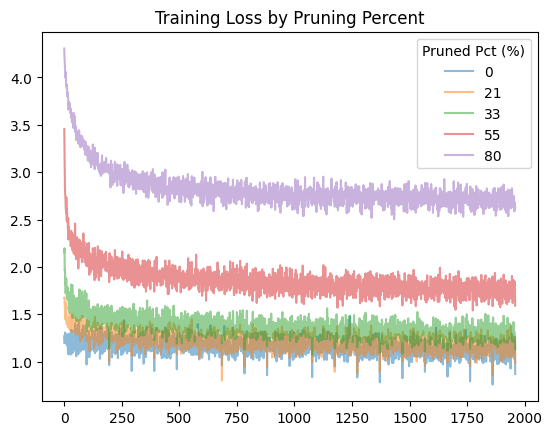

In [123]:
plt.plot(train_loss_dict[0], label="0", alpha=0.5)
plt.plot(train_loss_dict[3], label=pruned_pcts[2], alpha=0.5)
plt.plot(train_loss_dict[5], label=pruned_pcts[4], alpha=0.5)
plt.plot(train_loss_dict[10], label=pruned_pcts[9], alpha=0.5)
plt.plot(train_loss_dict[20], label=pruned_pcts[19], alpha=0.5)
plt.legend(title="Pruned Pct (%)")
plt.title("Training Loss by Pruning Percent")

### Part II: Validation accuracy across the pruned model checkpoints

Text(0.5, 1.0, 'Validation Accuracy by Pruning Percent')

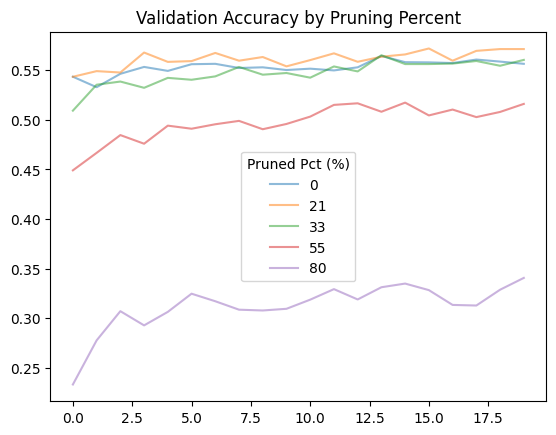

In [122]:
plt.plot(val_acc_dict[0], label="0", alpha=0.5)
plt.plot(val_acc_dict[3], label=pruned_pcts[2], alpha=0.5)
plt.plot(val_acc_dict[5], label=pruned_pcts[4], alpha=0.5)
plt.plot(val_acc_dict[10], label=pruned_pcts[9], alpha=0.5)
plt.plot(val_acc_dict[20], label=pruned_pcts[19], alpha=0.5)
plt.legend(title="Pruned Pct (%)")
plt.title("Validation Accuracy by Pruning Percent")

Our model performed better when pruned roughly 20-30%, and performance only began suffering beyond this threshold.